Note: [this notebook is run in R. please select a kernel for R.]  
Generate noiseless data and noisy data using Splatter.  
see https://github.com/Oshlack/splatter  
noisy data is Bernoulli dropout with dropout probability being a logistic function of the true count.  

In [1]:
# BiocManager::install("splatter", force=TRUE)
# install.packages("/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/splatter/", repos = NULL, type="source")

In [2]:
# Load package
suppressPackageStartupMessages({
  library(splatter)
  library(scater)
})
setwd('test_data_splatter')

In [3]:
params <- newSplatParams(
    # nGenes = 30000, batchCells = 8000, 
    nGenes = 5000, batchCells = 1000, 
    # nGenes = 1000, batchCells = 5000, 
    mean.shape = 0.5, de.prob = 0.2, 
    lib.loc = 12, lib.scale = 0.2,
    # dropout.type = 'none'
    dropout.type = "experiment",
    dropout.mid = 4,
    dropout.shape = -1,
    # dropout.mid = 2,
    # dropout.shape = -0.5,    
)

In [4]:
params

A Params object of class SplatParams 
Parameters can be (estimable) or [not estimable], 'Default' or  'NOT DEFAULT' 
Secondary parameters are usually set during simulation

Global: 
(GENES)  (CELLS)   [Seed] 
   5000     1000   757544 

29 additional parameters 

Batches: 
    [BATCHES]  [BATCH CELLS]     [Location]        [Scale]       [Remove] 
            1           1000            0.1            0.1          FALSE 

Mean: 
 (Rate)  (SHAPE) 
    0.3      0.5 

Library size: 
(LOCATION)     (Scale)      (Norm) 
        12         0.2       FALSE 

Exprs outliers: 
(Probability)     (Location)        (Scale) 
         0.05              4            0.5 

Groups: 
     [Groups]  [Group Probs] 
            1              1 

Diff expr: 
[PROBABILITY]    [Down Prob]     [Location]        [Scale] 
          0.2            0.5            0.1            0.4 

BCV: 
(Common Disp)          (DoF) 
          0.1             60 

Dropout: 
    [TYPE]  (MIDPOINT)     (Shape) 
experiment         

In [5]:
sim <- splatSimulate(params, sparsify=FALSE)

Getting parameters...

Creating simulation object...

Simulating library sizes...

Simulating gene means...

Simulating BCV...

Simulating counts...

Simulating dropout (if needed)...

Done!



In [6]:
sim

class: SingleCellExperiment 
dim: 5000 1000 
metadata(1): Params
assays(8): BatchCellMeans BaseCellMeans ... Dropout counts
rownames(5000): Gene1 Gene2 ... Gene4999 Gene5000
rowData names(4): Gene BaseGeneMean OutlierFactor GeneMean
colnames(1000): Cell1 Cell2 ... Cell999 Cell1000
colData names(3): Cell Batch ExpLibSize
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

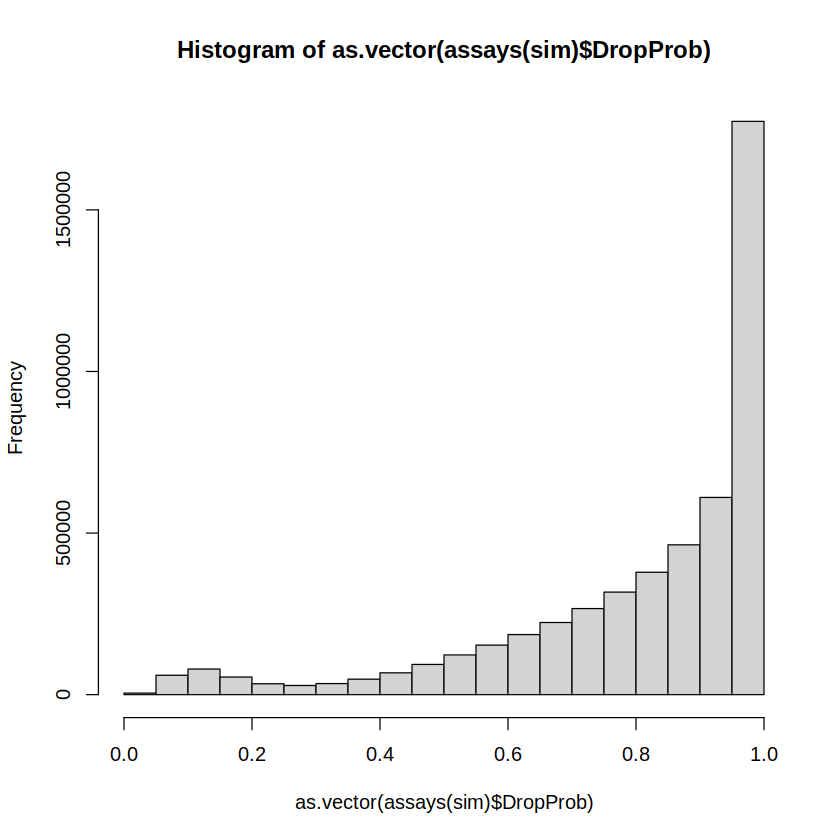

In [7]:
hist(as.vector(assays(sim)$DropProb))

In [8]:
write.csv(assays(sim)$CellMeans, 'cellmeans.csv')

In [9]:
write.csv(assays(sim)$TrueCounts, 'truecounts.csv')

In [10]:
write.csv(assays(sim)$counts, 'dropouted.csv')

In [11]:
write.csv(assays(sim)$DropProb, 'dropoutprob.csv')

In [12]:
# logistic <- function(x, x0, k) {
#     1 / (1 + exp(-k * (x - x0)))
# }

# splatSimDropout <- function(sim, params) {

#     dropout.type <- getParam(params, "dropout.type")
#     true.counts <- assays(sim)$TrueCounts
#     dropout.mid <- getParam(params, "dropout.mid")
#     dropout.shape <- getParam(params, "dropout.shape")
#     cell.names <- colData(sim)$Cell
#     gene.names <- rowData(sim)$Gene
#     nCells <- length(colData(sim)$Cell)
#     nGenes <- getParam(params, "nGenes")
#     nBatches <- getParam(params, "nBatches")
#     nGroups <- getParam(params, "nGroups")
#     cell.means <- assays(sim)$CellMeans

#     switch(dropout.type,
#            experiment = {
#                if ((length(dropout.mid) != 1) || length(dropout.shape) != 1) {
#                    stop("dropout.type is set to 'experiment' but dropout.mid ",
#                         "and dropout.shape aren't length 1")
#                }

#                dropout.mid <- rep(dropout.mid, nCells)
#                dropout.shape <- rep(dropout.shape, nCells)
#            },
#            batch = {
#                if ((length(dropout.mid) != nBatches) ||
#                    length(dropout.shape) != nBatches) {
#                    stop("dropout.type is set to 'batch' but dropout.mid ",
#                         "and dropout.shape aren't length equal to nBatches ",
#                         "(", nBatches, ")")
#                }

#                batches <- as.numeric(factor(colData(sim)$Batch))
#                dropout.mid <- dropout.mid[batches]
#                dropout.shape <- dropout.shape[batches]
#            },
#            group = {
#                if ((length(dropout.mid) != nGroups) ||
#                    length(dropout.shape) != nGroups) {
#                    stop("dropout.type is set to 'group' but dropout.mid ",
#                         "and dropout.shape aren't length equal to nGroups ",
#                         "(", nGroups, ")")
#                }

#                if ("Group" %in% colnames(colData(sim))) {
#                    groups <- as.numeric(colData(sim)$Group)
#                } else {
#                    stop("dropout.type is set to 'group' but groups have not ",
#                         "been simulated")
#                }

#                dropout.mid <- dropout.mid[groups]
#                dropout.shape <- dropout.shape[groups]
#            },
#            cell = {
#                if ((length(dropout.mid) != nCells) ||
#                    length(dropout.shape) != nCells) {
#                    stop("dropout.type is set to 'cell' but dropout.mid ",
#                         "and dropout.shape aren't length equal to nCells ",
#                         "(", nCells, ")")
#                }
#            })

#     if (dropout.type != "none") {

#         # Generate probabilities based on expression
#         drop.prob <- vapply(seq_len(nCells), function(idx) {
#             eta <- log(cell.means[, idx])
#             return(logistic(eta, x0 = dropout.mid[idx], k = dropout.shape[idx]))
#         }, as.numeric(seq_len(nGenes)))

#         # Decide which counts to keep
#         keep <- matrix(rbinom(nCells * nGenes, 1, 1 - drop.prob),
#                        nrow = nGenes, ncol = nCells)

#         counts <- true.counts * keep

#         colnames(drop.prob) <- cell.names
#         rownames(drop.prob) <- gene.names
#         colnames(keep) <- cell.names
#         rownames(keep) <- gene.names

#         assays(sim)$DropProb <- drop.prob
#         assays(sim)$Dropout <- !keep
#     } else {
#         counts <- true.counts
#     }

#     BiocGenerics::counts(sim) <- counts

#     return(sim)
# }


In [13]:
# assays(sim)$TrueCounts = assays(sim)$CellMeans
# params <- setParams(params, update = list(dropout.type = "experiment", dropout.mid = 5, dropout.shape = -1))
# sim_dropout <- splatSimDropout(sim, params)

In [14]:
# write.csv(assays(sim)$counts, 'dropouted_no_poisson.csv')

In [15]:
getwd()

[1] "/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/noise_MAGIC/test_data_splatter"